In [75]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

# Functions

In [76]:
def listkap_matkappa(kappa):
    matkappa = np.zeros((no_states,no_states))
    triangle = np.triu(np.ones((no_states, no_states), dtype=bool), k=1) 
    matkappa[triangle]= kappa
    matkappa += matkappa.T
    return matkappa

def matkappa_matr(kappa):
    matkappa = listkap_matkappa(kappa)
    matr = np.zeros((no_states,no_states)) 
    matr = matkappa * eq_pop[:, np.newaxis] 
    rdiag = -np.sum(matr,0)
    matr = matr + np.diag(rdiag)
    return matr

def p_model(exp_r_del_t, p_zero):
    p_model = np.zeros((time_size,no_states))

    p_model[0,:] = p_zero
    for i in range(1,time_size):
        p_model[i,:] = exp_r_del_t.dot(p_model[i-1,:])
    return p_model


# Residual for only kappa

In [77]:
def residual_kappaonly(kappa):
    r_of_t = matkappa_matr(kappa)
    expm_rdelt = expm(r_of_t*del_t)
    p_mod = p_model(expm_rdelt,p_zero)
    residual = (population_data-p_mod).flatten()
    return residual

# Data

In [97]:
column_names = ["Time"]
site_data_path = "/u/dem/kebl6911/Part-II/MASH_optimization/Data/mash_site300K.dat"

for i in range(1,8):
    column_names.append(str(i))
site_df = pd.read_csv(site_data_path, delimiter=" ", names=column_names)
site_df = site_df[(site_df.index % 10 == 0) | (site_df.index == len(site_df.index) - 1)]
site_eq = site_df.values 
full_time = site_df["Time"].values
#
site_df = site_df[site_df["Time"]<=1000]
site_values = site_df.values
site_full = site_values[:,1:]

t0_to_t1_pop = site_values[site_values[:,0]<=800]

t1_to_t2_pop = site_values[site_values[:,0]>800]
t1_to_t3_time = full_time[full_time[:]>800]
time_size = len(t1_to_t3_time)

del_t = t1_to_t3_time[1]- t1_to_t3_time[0]
no_states = 7
eq_pop = site_eq[-1]
eq_pop = eq_pop[1:8]

p_zero = site_values[site_values[:,0]>800]
p_zero = p_zero[0]
p_zero_800 = p_zero[1:8]
print(p_zero_800)

[0.3179426  0.20660395 0.20776209 0.12517032 0.06206283 0.02227419
 0.05818402]


# Residual for without p0

In [114]:
kappa_guess = np.full(21,0.01)
kappa = kappa_guess

t0_to_t1_time = full_time[full_time[:]<=800]
start_time_values = t0_to_t1[:-10]

t1_to_t2_time = full_time[full_time<=1000]
t1_to_t2_time = t1_to_t2[t1_to_t2>800]

save_kappas = []
save_resid = []

for index, start_time in enumerate(start_time_values, start=1):
    print(index)

    data_t0_t1 = t0_to_t1_pop[t0_to_t1_pop[:,0] >= start_time]
    data_t0_t1 = data_t0_t1[:-10, :]
    time_size = len(start_time_values)
    data_t0_t1 = data_t0_t1[:,1:]
    population_data = data_t0_t1[::-1]
    p_zero = p_zero_800
    del_t = -del_t
    
    least_squares_result = least_squares(residual_kappaonly, kappa, bounds=(0,float("inf")))# verbose=0, xtol=None, ftol=1e-8) # bounds=(-float("inf"),1e-17)

    kappa_optimized = least_squares_result.x
    save_kappas.append(kappa_optimized)
    kappa = kappa_optimized
    population_data = t1_to_t2_pop[:,1:]
    time_size = len(t1_to_t2_time)
    del_t = -del_t

    resid = residual_kappaonly(kappa_optimized)
    resid = np.sum(np.abs(resid))/(time_size*7)

    save_resid.append(resid)

save_kappas = np.column_stack((start_time_values,save_kappas))
save_resid = np.column_stack((start_time_values,save_resid))

np.savetxt(f"/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/800_1000_resid3.dat", save_resid, delimiter = "\t")
np.savetxt(f"/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/800_1000_kap_saved3.dat",save_kappas, delimiter = "\t")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


/u/dem/kebl6911/anaconda3/envs/project1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156


Text(0.5, 0, '$t_0$ [fs]')

/u/dem/kebl6911/anaconda3/envs/project1/lib/python3.11/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


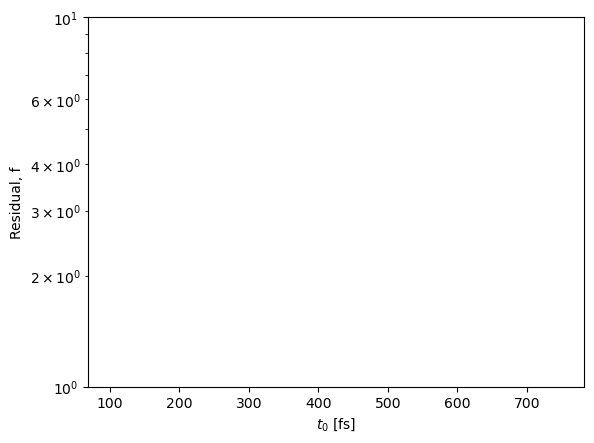

In [115]:
site_residual_data = np.loadtxt("/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/800_1000_resid3.dat")

plt.semilogy(site_residual_data[:,0],site_residual_data[:,1])

plt.ylabel('Residual, f')
plt.xlabel(r'$t_0$ [fs]')

# Kappa from 449.9 fs without optimizing p0

In [110]:
kappas = np.loadtxt("/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/800_1000_kap_saved3.dat")

kappa_450 = kappas[64]

kappa_450 = kappa_450[1:22]

print(kappa_450)

[7.65140863e-02 3.95959125e-55 3.09188818e-53 4.34028655e-51
 4.18137098e-51 2.65150620e-51 3.39702461e-54 9.20540336e-52
 3.39349786e-50 2.88065516e-49 4.45951611e-53 8.82748449e-02
 3.23352913e-38 5.46699405e-01 2.67319719e-03 5.91179654e-40
 2.78830176e-01 1.16991167e-01 9.07496139e-33 3.80754384e-46
 5.73149393e-05]


# Computing Populations from Kappa - 449.9 fs without optimizing p0

In [112]:
time_size = len(t1_to_t3)
r_matrix = matkappa_matr(kappa_450) 
expm_rt = expm(r_matrix*del_t)
pop_450 = p_model(expm_rt, p_zero_800)

pop_450 = np.column_stack((t1_to_t3, pop_450))
np.savetxt("/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/pop_450.dat", pop_450, delimiter = "\t")

/u/dem/kebl6911/anaconda3/envs/project1/lib/python3.11/site-packages/matplotlib/axes/_base.py:2914: RuntimeWarning: overflow encountered in scalar subtract
  delta = (x1t - x0t) * margin


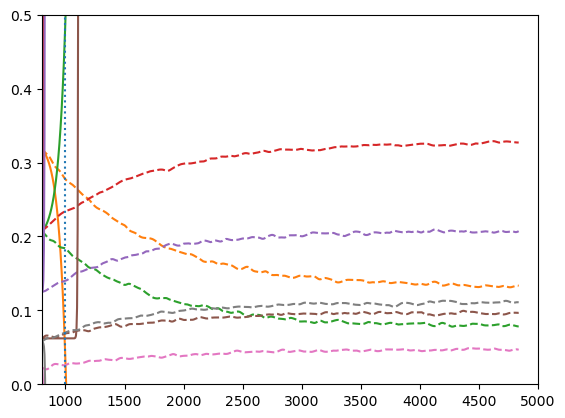

In [113]:
site_data = np.loadtxt(site_data_path)

saved_450 = np.loadtxt("/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/pop_450.dat")

for i, column_name in enumerate(column_names[1:], start=1):
    c = "C%i"%i
    plt.plot(site_data[:,0], site_data[:,i],"--", label=column_name, color=c)
    plt.plot(saved_450[:,0],saved_450[:,i], "-",color=c)

plt.ylim(0,0.5)
plt.xlim(800,5000)
plt.axvline(x=1000, linestyle = ":")
plt.show()